### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file



Populating the interactive namespace from numpy and matplotlib


In [17]:
data_dir='../../Data/Weather'
file_index='SSSSBSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT measurement, count(measurement) FROM weather\n\tGROUP BY measurement"
print Query
df1 = sqlContext.sql(Query)
df1.show()





keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12791
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    938.8| 32.1794|-110.7364|       TMAX|USC00027398|    10|[B0 58 10 5A 40 5...|2010.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMAX|USC00027398|    16|[00 53 80 54 08 5...|2011.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMAX|USC00027398|    32|[A0 5B D0 5B 48 5...|2012.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMIN|USC00027398|    16|[00 4F 80 51 00 5...|2010.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMIN|USC00027398|    19|[40 D2 40 D2 40 D...|2011.0|SSSSBSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows

SELECT measur

In [18]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT longitude FROM weather\n\tGROUP BY longitude  ORDER BY longitude"
print Query
df0 = sqlContext.sql(Query)
df0.show()

Query="SELECT latitude FROM weather\n\tGROUP BY latitude ORDER BY latitude "
print Query
df0 = sqlContext.sql(Query)
df0.show() 

SELECT longitude FROM weather
	GROUP BY longitude  ORDER BY longitude
+---------+
|longitude|
+---------+
|-111.7117|
|-111.6917|
| -111.689|
| -111.684|
|-111.6819|
|-111.6692|
|-111.6314|
|-111.5699|
|-111.5367|
|-111.5325|
|-111.5186|
|-111.5127|
|-111.5072|
|   -111.5|
|-111.4667|
|-111.4649|
|-111.4017|
|-111.3881|
|-111.3333|
|-111.2864|
+---------+
only showing top 20 rows

SELECT latitude FROM weather
	GROUP BY latitude ORDER BY latitude 
+--------+
|latitude|
+--------+
| 32.1314|
| 32.1342|
| 32.1366|
| 32.1383|
| 32.1389|
|  32.139|
| 32.1453|
| 32.1667|
| 32.1794|
| 32.1883|
| 32.1923|
| 32.2056|
| 32.2144|
| 32.2156|
| 32.2163|
| 32.2168|
|  32.224|
| 32.2261|
| 32.2279|
| 32.2292|
+--------+
only showing top 20 rows



In [19]:
Query="SELECT station, count(station) FROM weather\n\tGROUP BY station \n\t ORDER BY count(station) DESC"
print Query
df2 = sqlContext.sql(Query)
df2.show()



SELECT station, count(station) FROM weather
	GROUP BY station 
	 ORDER BY count(station) DESC
+-----------+--------------+
|    station|count(station)|
+-----------+--------------+
|USC00021849|           607|
|USC00028815|           596|
|USC00029334|           592|
|USC00020958|           518|
|USC00023027|           499|
|USC00021314|           495|
|USC00021306|           432|
|USC00028348|           391|
|USC00027480|           385|
|USC00027390|           383|
|USC00028796|           366|
|USC00027560|           352|
|USC00021514|           325|
|USW00023160|           323|
|USC00028800|           321|
|USC00026119|           318|
|USC00027388|           267|
|USC00022807|           254|
|USC00029420|           247|
|USC00023150|           233|
+-----------+--------------+
only showing top 20 rows



### Select data for a particular station and measurement type

In [20]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00021849')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
print len(rows)
T=np.vstack(rows)
#print T[0]
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)
#print T[0]

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00021849'
112 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1072.9| 33.0561|-109.3072|       PRCP|USC00021849|    44|[00 00 00 00 00 0...|1895.0|SSSSBSSB|
|   1072.9| 33.0561|-109.3072|       PRCP|USC00021849|     2|[00 00 00 00 00 0...|1896.0|SSSSBSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

112


(112, 365)

### Script for plotting yearly plots

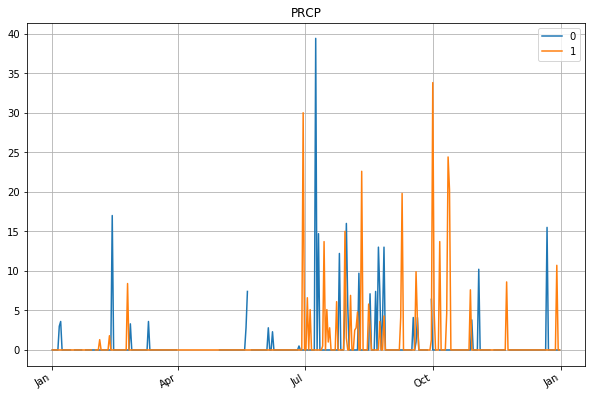

In [21]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

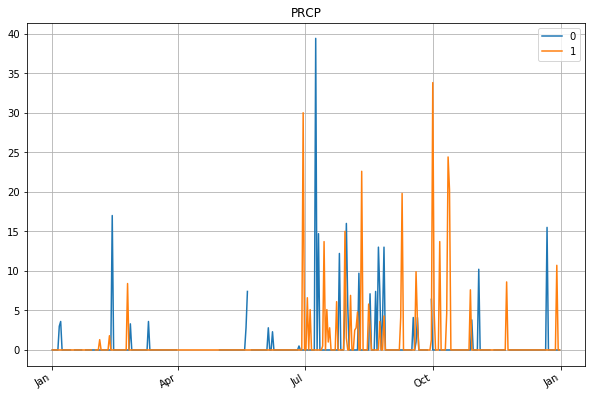

In [22]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [23]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

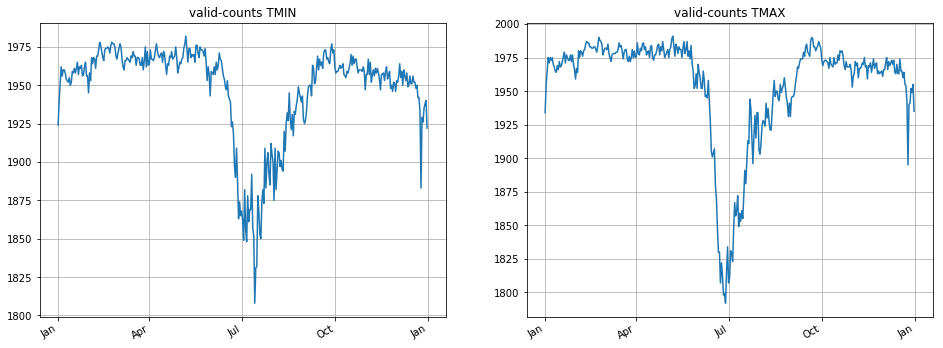

In [24]:
plot_pair(['TMIN','TMAX'],plot_valid)

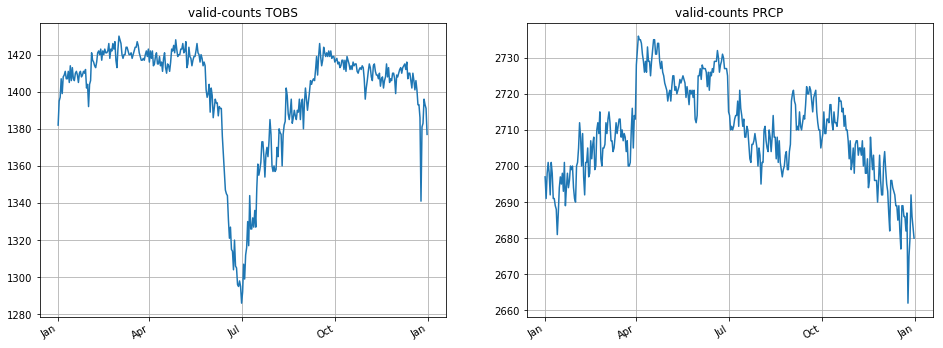

In [25]:
plot_pair(['TOBS','PRCP'],plot_valid)

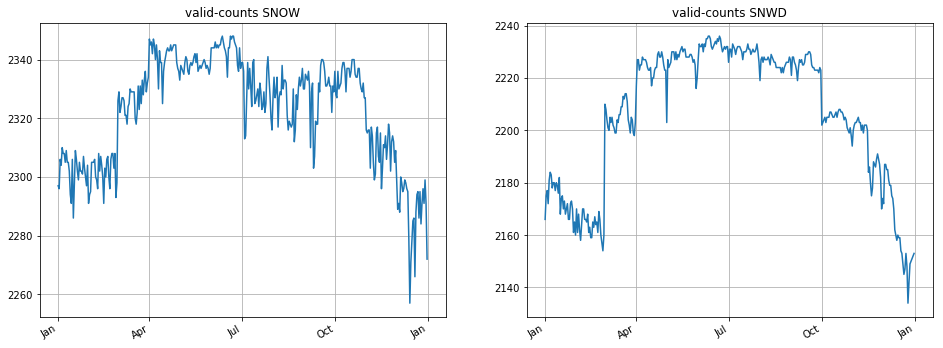

In [26]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [31]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs/10.0,fig,axis,title='Mean+-std   '+m)

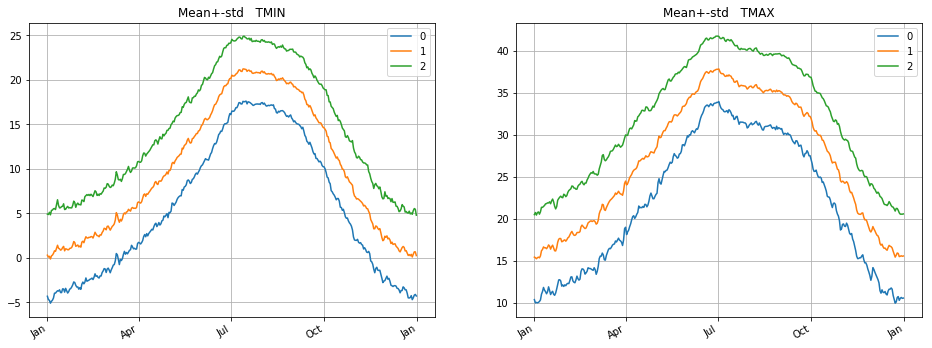

In [32]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

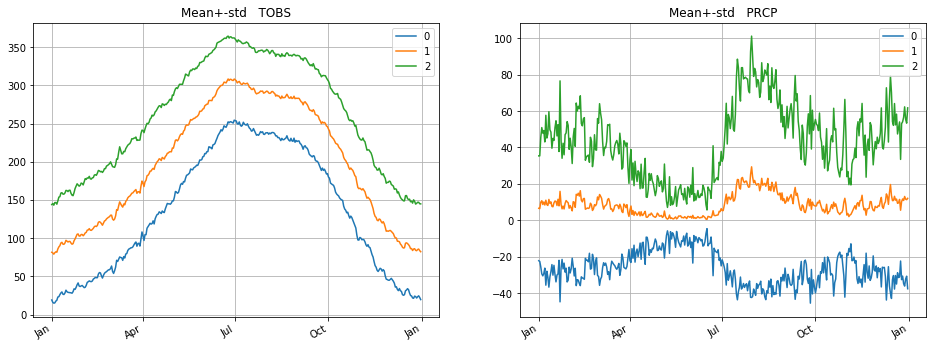

In [15]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

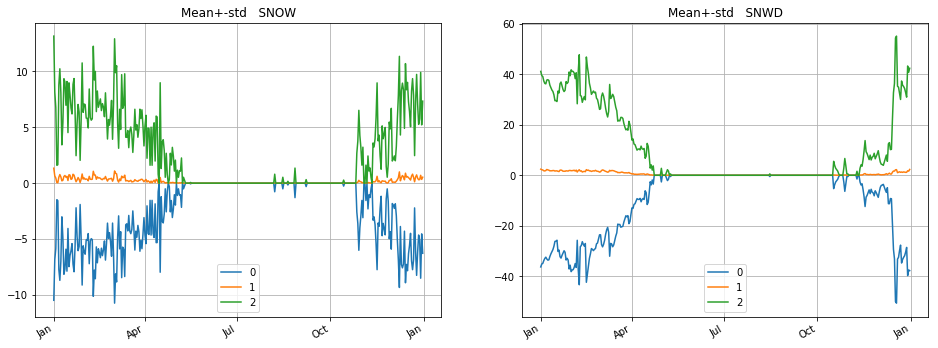

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [33]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

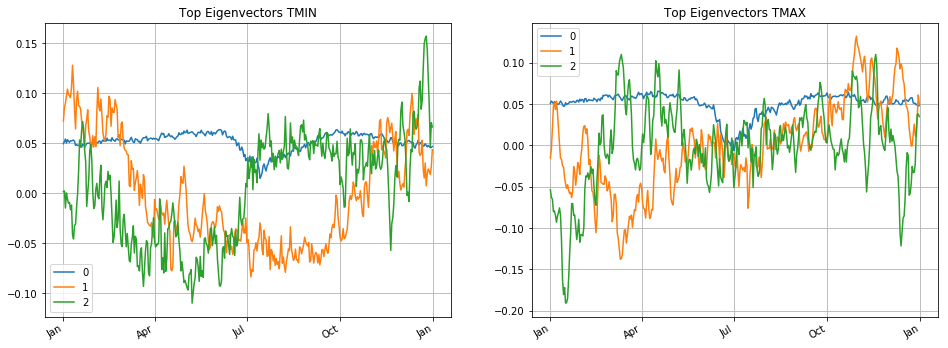

In [34]:
plot_pair(['TMIN','TMAX'],plot_eigen)

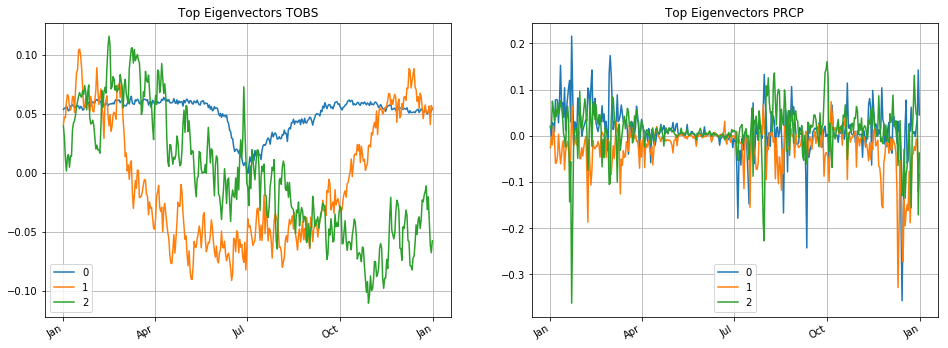

In [35]:
plot_pair(['TOBS','PRCP'],plot_eigen)

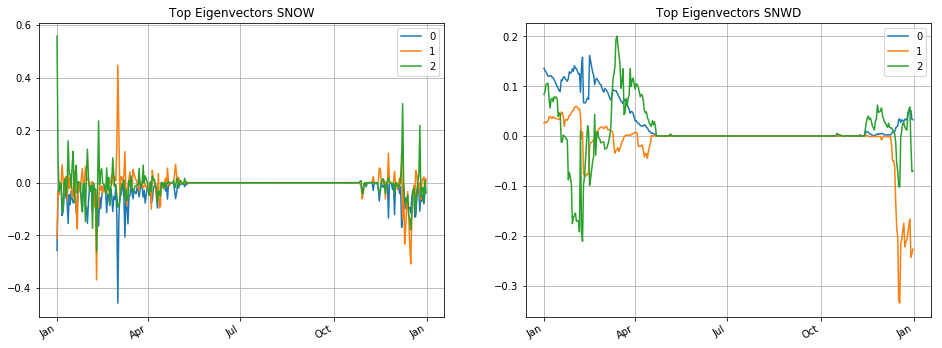

In [36]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [37]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

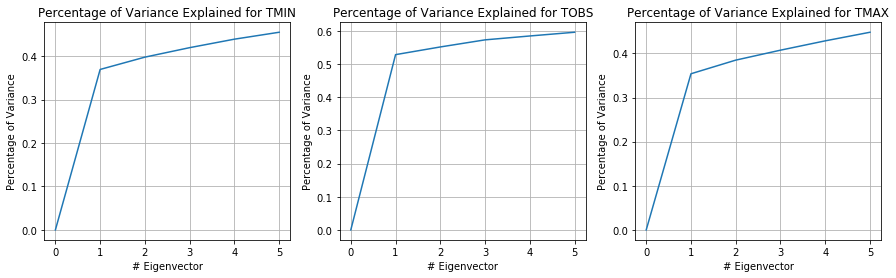

In [38]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

In [ ]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [ ]:
#sc.stop()